# Final model with just the selected parameters

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import scipy.stats as stats
import sklearn.linear_model as linear_model
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import QuantileTransformer, PowerTransformer

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('part-00000-03fb537b-9382-4a5b-bac8-26d245ab88ab-c000.csv')

In [3]:
df.head()

,x005,x276,x056,x193,x171,x075,x275,x281,x236,x057,...,x059,x055,x076,x274,x239,x245,x287,x014,x003,y
0,8.0,0,0,0,0,0,NaN,0,0,NaN,...,0,0,0,0,NaN,1,NaN,0,NaN,706
1,4.0,0,0,0,0,22375,NaN,5206,0,NaN,...,8,0,0,0,NaN,0,1.0,0,3.0,558
2,96.0,0,2,0,0,3287,0.4814,0,0,NaN,...,3,0,1,1613,NaN,1,NaN,0,NaN,577
3,258.0,1,2,8,0,684,1.1153,0,-156,1.52,...,5,0,1,4796,14.0,1,2.0,1,14.0,526
4,34.0,1,0,1,1,2810,0.1430,0,710,0.62,...,7,0,0,186,29.5,1,NaN,0,25.0,496


In [4]:
features = df[df.columns.difference(['y'])]
target = df.y

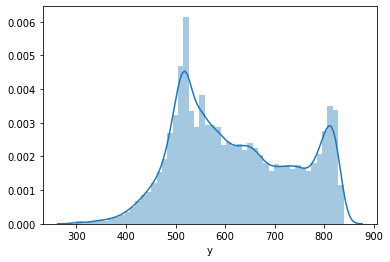

In [5]:
sns.distplot(target)

# Train test split

In [6]:
column_names = features.columns

In [7]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=12345)

In [8]:
y_train = np.array(y_train).reshape(y_train.size,1)
y_test = np.array(y_test).reshape(y_test.size,1)

# Median imputation

In [9]:
median_values = X_train.median()

In [10]:
X_train = X_train.fillna(median_values)
X_test = X_test.fillna(median_values)

# Test for normality

In [11]:
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = X_train.apply(test_normality)
print(not normal.any())

False


# Spearman correlation

In [12]:
corr = X_train.corr(method='spearman')

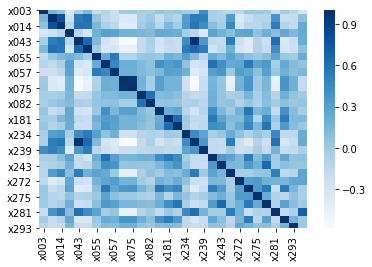

In [13]:
sns.heatmap(corr, cmap="Blues")

# Quantile transformer for target column

In [14]:
qt_target = QuantileTransformer(n_quantiles=30, output_distribution='normal', random_state=12345)
qt_target.fit(y_train)
y_train = qt_target.transform(y_train)
y_test = qt_target.transform(y_test)

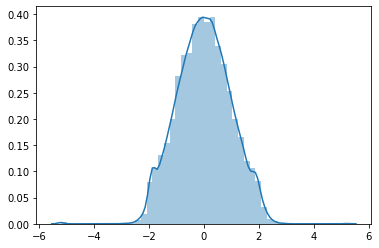

In [15]:
sns.distplot(y_train)

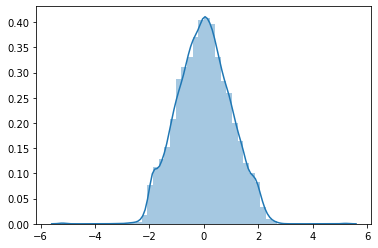

In [16]:
sns.distplot(y_test)

In [17]:
y_train = y_train.ravel()
y_test = y_test.ravel()

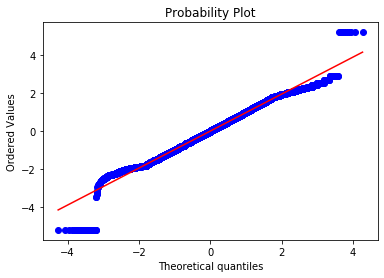

In [18]:
fig = plt.figure()
res = stats.probplot(y_train, plot=plt)
plt.show()

# Detecting outliers in each column using IQR

In [19]:
Q1 = X_train.quantile(0.25)
Q3 = X_train.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

x003       13.000000
x005      144.000000
x014        7.000000
x036        4.000000
x043    10433.000000
x044    13250.000000
x055        0.000000
x056        1.000000
x057        0.400925
x059        3.000000
x075     1869.000000
x076        0.000000
x082        0.000000
x171        0.000000
x181        2.000000
x193        0.000000
x234     2354.000000
x236     9748.250000
x239       40.500000
x240        1.000000
x243        0.000000
x245        1.000000
x272        0.443600
x274      870.000000
x275        0.000000
x276        0.000000
x281    35812.500000
x287        3.000000
x293        0.000000
x296    12905.500000
dtype: float64


# Replace outliers with the allowed values using IQR

In [20]:
down_quantiles = Q1 - 1.5 * IQR
up_quantiles = Q3 + 1.5 * IQR

def apply_mask(df):
    outliers_low = (df < down_quantiles)
    outliers_high = (df > up_quantiles)
    
    df_out = df.mask(outliers_low, down_quantiles, axis=1)
    df_out = df.mask(outliers_high, up_quantiles, axis=1)
    
    return df_out

In [21]:
X_train = apply_mask(X_train)
X_test = apply_mask(X_test)

In [22]:
X_train.shape, X_test.shape

((70000, 30), (30000, 30))

# Find skewed numerical features

In [23]:
skew_features = X_train.apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features

There are 19 numerical features with Skew > 0.5 :


x056    1.757701
x181    1.431244
x287    1.389218
x296    1.268358
x075    1.235161
x236    1.229306
x043    1.222729
x044    1.203034
x274    1.199187
x059    1.190632
x281    1.183416
x234    1.170227
x014    1.166037
x003    1.117701
x036    1.108242
x272    0.923258
x240    0.840802
x005    0.782386
x239    0.774582
x055    0.000000
x276    0.000000
x076    0.000000
x171    0.000000
x193    0.000000
x243    0.000000
x082    0.000000
x057   -0.392117
x245   -1.033928
x275   -1.800916
x293   -2.786430
dtype: float64

# Fix Skewed features

In [24]:
pt_inputs = PowerTransformer(method='yeo-johnson')
pt_inputs.fit(X_train)
X_train = pd.DataFrame(pt_inputs.transform(X_train), columns=column_names)
X_test = pd.DataFrame(pt_inputs.transform(X_test), columns=column_names)

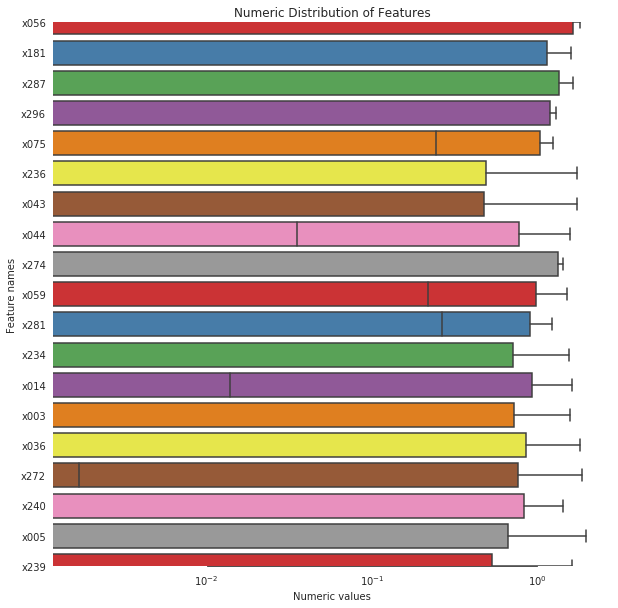

In [25]:
sns.set_style("white")
f, ax = plt.subplots(figsize=(10, 10))
ax.set_xscale("log")
ax = sns.boxplot(data=X_train[skew_index] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [26]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X_train):
    rmse = np.sqrt(-cross_val_score(model, X, y_train, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [27]:
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [28]:
# Ridge Regressor
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kfolds))

In [29]:
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))       

In [30]:
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

In [31]:
gbr = GradientBoostingRegressor(n_estimators=5000, 
                                learning_rate=0.01, 
                                max_depth=4, 
                                max_features='sqrt', 
                                min_samples_leaf=15, 
                                min_samples_split=10, 
                                loss='huber', 
                                random_state =42)    

In [32]:
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

In [33]:
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=5000,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

In [34]:
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [35]:
score = cv_rmse(ridge)
print("RIDGE: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lasso)
print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(elasticnet)
print("elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

RIDGE: 0.4047 (0.0067)
 2020-08-05 02:54:31.432617
LASSO: 0.4046 (0.0067)
 2020-08-05 02:54:37.994321
elastic net: 0.4046 (0.0067)
 2020-08-05 02:55:02.411043
SVR: 0.3865 (0.0075)
 2020-08-05 03:46:39.998972
lightgbm: 0.3377 (0.0053)
 2020-08-05 03:47:19.050772
gbr: 0.3191 (0.0063)
 2020-08-05 04:39:47.839308
xgboost: 0.3238 (0.0055)
 2020-08-05 05:31:17.136917


In [36]:
print('START Fit')

print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X_train), np.array(y_train))

print('elasticnet')
elastic_model_full_data = elasticnet.fit(X_train, y_train)

print('Lasso')
lasso_model_full_data = lasso.fit(X_train, y_train)

print('Ridge')
ridge_model_full_data = ridge.fit(X_train, y_train)

print('Svr')
svr_model_full_data = svr.fit(X_train, y_train)

print('GradientBoosting')
gbr_model_full_data = gbr.fit(X_train, y_train)

print('xgboost')
xgb_model_full_data = xgboost.fit(X_train, y_train)

print('lightgbm')
lgb_model_full_data = lightgbm.fit(X_train, y_train)

START Fit
stack_gen
elasticnet
Lasso
Ridge
Svr
GradientBoosting
xgboost
lightgbm


In [37]:
def blend_models_predict(X):
    return ((0.1 * elastic_model_full_data.predict(X)) + \
            (0.05 * lasso_model_full_data.predict(X)) + \
            (0.1 * ridge_model_full_data.predict(X)) + \
            (0.1 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.15 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.3 * stack_gen_model.predict(np.array(X))))

In [38]:
pred_train = blend_models_predict(X_train)

In [40]:
pred_test = blend_models_predict(X_test)

In [44]:
y_train = np.array(y_train).reshape(y_train.size,1)
y_test = np.array(y_test).reshape(y_test.size,1)
y_train = qt_target.inverse_transform(y_train)
y_test = qt_target.inverse_transform(y_test)

In [47]:
pred_train = np.array(pred_train).reshape(pred_train.size,1)
pred_test = np.array(pred_test).reshape(pred_test.size,1)
pred_train = qt_target.inverse_transform(pred_train)
pred_test = qt_target.inverse_transform(pred_test)

In [52]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt 

# define model evaluation rmse function
def rmse(y, pred):
    rmse = sqrt(mean_squared_error(y, pred))
    return rmse

# define accuracy evaluation function
def accuracy(y, pred):
    accuracy = (np.abs(y - pred) <= 3).astype(int)
    return np.sum(accuracy)/len(accuracy)

# define model fit function
def model_evaluate(y_train, pred_train, y_test, pred_test):
    
    temp_y_train = y_train.ravel()
    temp_y_test = y_test.ravel()
    pred_train = pred_train.ravel()
    pred_test = pred_test.ravel()
    
    rmse_train = rmse(temp_y_train, pred_train)
    rmse_test = rmse(temp_y_test, pred_test)
    acc_train = accuracy(temp_y_train, pred_train)
    acc_test = accuracy(temp_y_test, pred_test)
    r2_train = r2_score(temp_y_train, pred_train)
    r2_test = r2_score(temp_y_test, pred_test)
    
    print("\n")
    print("Train RMSE - ", rmse_train)
    print("Test RMSE - ", rmse_test)
    print("\n")
    print("Train Accuracy - ", acc_train)
    print("Test Accuracy - ", acc_test)
    print("\n")
    print("Train R squared - ", r2_train)
    print("Test R squared - ", r2_test)

    return rmse_train, rmse_test, acc_train, acc_test, r2_train, r2_test

In [53]:
model_evaluate(y_train, pred_train, y_test, pred_test)



Train RMSE -  34.628502197260985
Test RMSE -  35.08141669242041


Train Accuracy -  0.10208571428571428
Test Accuracy -  0.10076666666666667


Train R squared -  0.9147354542762038
Test R squared -  0.911851268507622


(34.628502197260985,
 35.08141669242041,
 0.10208571428571428,
 0.10076666666666667,
 0.9147354542762038,
 0.911851268507622)

# Min Max scaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(imputed_X_train)
X_train = pd.DataFrame(scaler.transform(imputed_X_train), columns=imputed_X_train.columns)
X_test = pd.DataFrame(scaler.transform(imputed_X_test), columns=imputed_X_test.columns)

# Model Evaluation metrics helper functions

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt 

# define model evaluation rmse function
def rmse(y, pred):
    rmse = sqrt(mean_squared_error(y, pred))
    return rmse

# define accuracy evaluation function
def accuracy(y, pred):
    accuracy = (np.abs(y - pred) <= 3).astype(int)
    return np.sum(accuracy)/len(accuracy)

# define model fit function
def model_fit(reg, X_train, X_test, y_train, y_test, min_value, max_value):
    
    reg.fit(X_train, y_train.ravel())

    #prediction results
    pred_train = reg.predict(X_train)
    pred_test = reg.predict(X_test)    
    pred_train[pred_train > max_value] = max_value
    pred_test[pred_test > max_value] = max_value
    pred_train[pred_train < min_value] = min_value
    pred_test[pred_test < min_value] = min_value
    
    if max_value == 1:
        pred_train = pred_train * 550 + 300
        pred_test = pred_test * 550 + 300
        temp_y_train = y_train.ravel() * 550 + 300
        temp_y_test = y_test.ravel() * 550 + 300
    else:    
        temp_y_train = y_train.ravel()
        temp_y_test = y_test.ravel()
    
    rmse_train = rmse(temp_y_train, pred_train)
    rmse_test = rmse(temp_y_test, pred_test)
    acc_train = accuracy(temp_y_train, pred_train)
    acc_test = accuracy(temp_y_test, pred_test)
    r2_train = r2_score(temp_y_train, pred_train)
    r2_test = r2_score(temp_y_test, pred_test)
    
    print("\n")
    print("Train RMSE - ", rmse_train)
    print("Test RMSE - ", rmse_test)
    print("\n")
    print("Train Accuracy - ", acc_train)
    print("Test Accuracy - ", acc_test)
    print("\n")
    print("Train R squared - ", r2_train)
    print("Test R squared - ", r2_test)

    return rmse_train, rmse_test, acc_train, acc_test, r2_train, r2_test

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb

In [ ]:
#reg = RandomForestRegressor()
reg = xgb.XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)
#reg = GradientBoostingRegressor

In [ ]:
rmse_train, rmse_test, acc_train, acc_test, r2_train, r2_test = model_fit(reg, X_train, X_test,
                                                                          y_train, y_test, 300, 850)

In [ ]:
rmse_train, rmse_test, acc_train, acc_test, r2_train, r2_test = model_fit(reg, X_train, X_test,
                                                                          scaled_y_train, 
                                                                          scaled_y_test, 0, 1)

In [ ]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [ ]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform('n_estimators', 10, 1000, 1),
        'seed': 0
    }

In [ ]:
def objective(space):
    clf=xgb.XGBRegressor(
                    n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    model_accuracy = accuracy(y_test, pred)
    print ("SCORE:", model_accuracy)
    return {'loss': -model_accuracy, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

In [ ]:
from scipy import stats

fig = plt.figure()
res = stats.probplot(np.log1p(y_train), plot=plt)
plt.show()